# Depth Model

## Loading input

In [1]:
import pickle, os, math, random
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the dataset
df = pd.read_csv('dataset/df_depth_2308.csv', index_col = 0)

# Sort the data in ascending order based on the 'opdate' column (most recent first)
df.sort_values(by=['opdate'], ascending=True, inplace=True)

# Extract features (x) and target (y) values from the dataFrame
x = df[['age_cal', 'sex', 'weight', 'height', 'cuffed']].astype(float).values
y = df['fixed'].astype(float).values
y_size = df['airway_tube_size'].astype(float).values
c = df['opid'].values

# Separate the data for cuffed and uncuffed endotracheal tubes
## Cuffed endotrahceal tube
x_cuffed = x[x[:, 4] == 1][:, :4]
y_cuffed = y[x[:, 4] == 1]
size_cuff = y_size[x[:,4] == 1]

# Determine the size of the test and train sets for cuffed data
nsamp = len(y_cuffed)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest

# Split the cuffed data into training and test sets
x_cuff_test = x_cuffed[-ntest:, :]
y_cuff_test = y_cuffed[-ntest:]
x_cuff_train = x_cuffed[:ntrain, :]
y_cuff_train = y_cuffed[:ntrain]
size_cuff_train = size_cuff[:ntrain]
size_cuff_test = size_cuff[-ntest:]

# Impute missing values in the cuffed data using the multiple imputation method
imp = IterativeImputer().fit(x_cuff_train)
x_cuff_train = imp.transform(x_cuff_train)
x_cuff_test = imp.transform(x_cuff_test)

## Uncuffed endotracheal tube
x_uncuffed = x[x[:, 4] == 0][:, :4]
y_uncuffed = y[x[:, 4] == 0]
size_uncuff = y_size[x[:, 4] == 0]

# Determine the size of the test and train sets for uncuffed data
nsamp = len(y_uncuffed)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest

# Split the uncuffed data into training and test sets
x_uncuff_test = x_uncuffed[-ntest:, :]
y_uncuff_test = y_uncuffed[-ntest:]
x_uncuff_train = x_uncuffed[:ntrain, :]
y_uncuff_train = y_uncuffed[:ntrain]
size_uncuff_train = size_uncuff[:ntrain]
size_uncuff_test = size_uncuff[-ntest:]

# Impute missing values in the uncuffed data using the multiple imputation method
imp = IterativeImputer().fit(x_uncuff_train)
x_uncuff_train = imp.transform(x_uncuff_train)
x_uncuff_test = imp.transform(x_uncuff_test)

# Print the shapes of the cuffed and uncuffed training and test sets
print(f'x_cuff_train: {(x_cuff_train).shape}, x_cuff_test: {x_cuff_test.shape}')
print(f'x_uncuff_train: {(x_uncuff_train).shape}, x_uncuff_test: {x_uncuff_test.shape}')

x_cuff_train: (9336, 4), x_cuff_test: (2334, 4)
x_uncuff_train: (16304, 4), x_uncuff_test: (4076, 4)


In [5]:
# numba 커널 버전
import pickle, os, math, random
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the dataset
dat = np.load(f'dataset/ETT_depth_2308.npz')
x, y = dat['x'], dat['y']

# Determine the size of the test and train sets
nsamp = len(x)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest

# Split the data into training and test sets
x_test = x[-ntest:, :]
y_test = y[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

# Impute missing values in the cuffed data using the multiple imputation method
imp = IterativeImputer().fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)


# Print the shapes of training and test sets
print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (25640, 5), x_test: (6410, 5)


## Feature Selection (BorutaShap)

### cuffed + uncuffed

/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [08:48<00:00,  5.29s/it]


4 attributes confirmed important: ['sex', 'weight', 'height', 'age']
0 attributes confirmed unimportant: []
0 tentative attributes remains: []


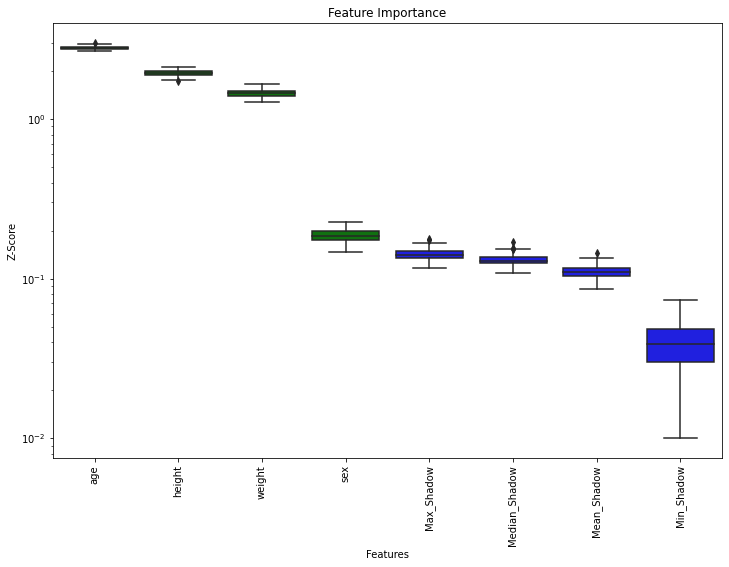

In [4]:
import pandas as pd
import xgboost as xgb
from BorutaShap import BorutaShap

# Define the input variables (features) and target variable (label)
INPUT_VARS = ['age', 'sex', 'weight', 'height']
TARGET_VAR = 'fixed_depth'

# Create a DataFrame with the training features (X) from the data
X = pd.DataFrame(x_train, columns=INPUT_VARS)

# Set a random seed for reproducibility
SEED = 98

# Create an XGBoost Regressor model
xgbr = xgb.XGBRegressor()

# Initialize the BorutaShap feature selector
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

# Fit the feature selector to the data
Feature_Selector.fit(X=X, 
                     y=y_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test='train', 
                     normalize=True, 
                     verbose=True, 
                     random_state=SEED)

# Plot the results of the BorutaShap feature selection
Feature_Selector.plot(X_size=10,
                       which_features='all')

In [8]:
import shap
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import pandas as pd


# xgbr에 내장된 함수 이용
#xgbr = xgb.XGBRegressor()
#xgbr.load_model('result/revision1/depth/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')

shap.initjs()
explainer = shap.TreeExplainer(gbrt)
shap_values = explainer.shap_values(x_train)

/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


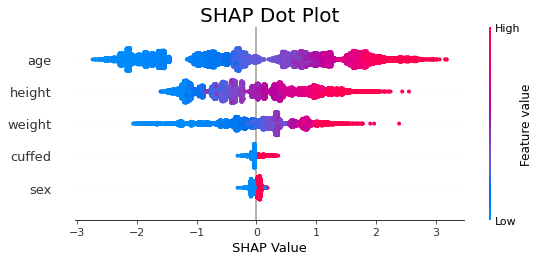

In [10]:
import matplotlib.pyplot as plt

INPUT_VARS = ['age','sex','weight','height', 'cuffed']

X_train = pd.DataFrame(x_train, columns=INPUT_VARS)

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, show=False)
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

In [2]:
# Exclude the 'cuffed' feature and concatenate 'age', 'sex', 'weight', and 'height' features into a new feature set
x_train = x_train[:,0:4]
x_test = x_test[:,0:4]

### Uncuffed

/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [03:44<00:00,  2.24s/it]


4 attributes confirmed important: ['height', 'age', 'sex', 'weight']
0 attributes confirmed unimportant: []
0 tentative attributes remains: []


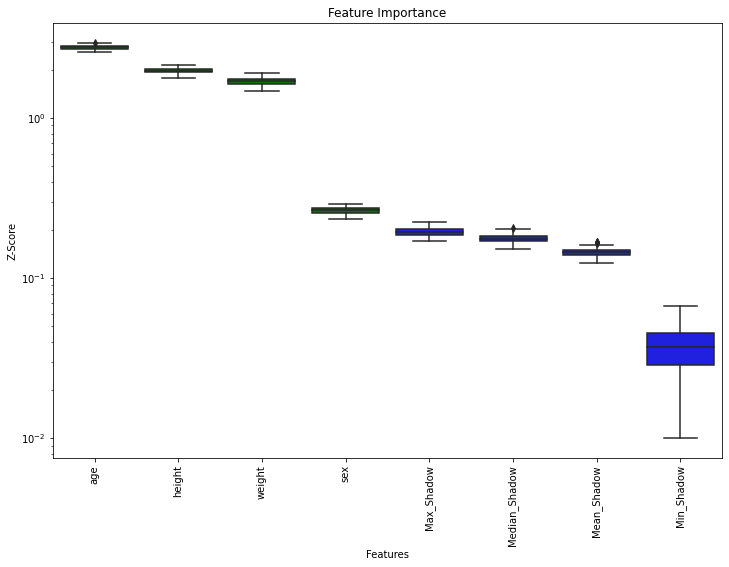

In [3]:
import pandas as pd
import xgboost as xgb
from BorutaShap import BorutaShap

# Define the input variables (features) and target variable (label)
INPUT_VARS = ['age', 'sex', 'weight', 'height']
TARGET_VAR = 'fixed_depth'

# Create a DataFrame with the training features (X) from the data
X = pd.DataFrame(x_uncuff_train, columns=INPUT_VARS)

# Set a random seed for reproducibility
SEED = 98

# Create an XGBoost Regressor model
xgbr = xgb.XGBRegressor()

# Initialize the BorutaShap feature selector
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

# Fit the feature selector to the data
Feature_Selector.fit(X=X, 
                     y=y_uncuff_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test='train', 
                     normalize=True, 
                     verbose=True, 
                     random_state=SEED)

# Plot the results of the BorutaShap feature selection
Feature_Selector.plot(X_size=10,
                       which_features='all')

### Cuffed

100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


3 attributes confirmed important: ['height', 'age', 'weight']
1 attributes confirmed unimportant: ['sex']
0 tentative attributes remains: []


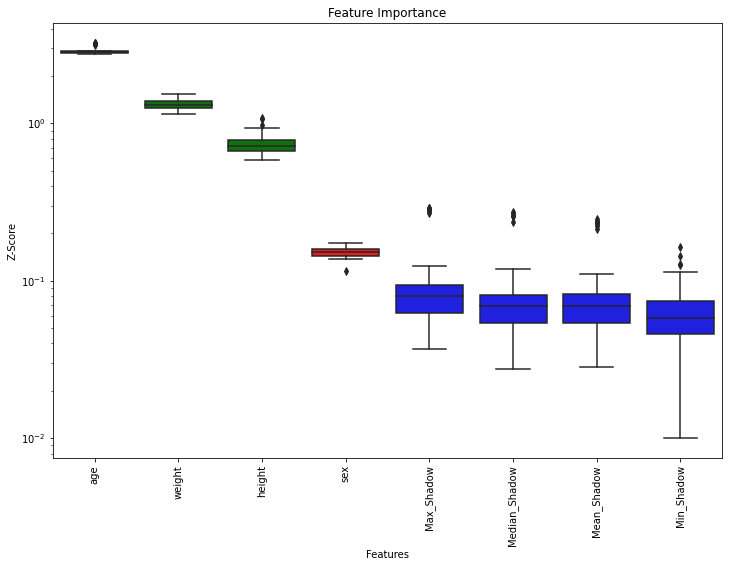

In [4]:
import pandas as pd
import xgboost as xgb
from BorutaShap import BorutaShap

# Define the input variables (features) and target variable (label)
INPUT_VARS = ['age', 'sex', 'weight', 'height']
TARGET_VAR = 'fixed_depth'

# Create a DataFrame with the training features (X) from the data
X = pd.DataFrame(x_cuff_train, columns=INPUT_VARS)

# Set a random seed for reproducibility
SEED = 98

# Create an XGBoost Regressor model
xgbr = xgb.XGBRegressor()

# Initialize the BorutaShap feature selector
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

# Fit the feature selector to the data
Feature_Selector.fit(X=X, 
                     y=y_cuff_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test='train', 
                     normalize=True, 
                     verbose=True, 
                     random_state=SEED)

# Plot the results of the BorutaShap feature selection
Feature_Selector.plot(X_size=10,
                       which_features='all')

In [2]:
# Exclude the 'sex' feature and concatenate 'age', 'weight', and 'height' features into a new feature set
x_cuff_train = np.concatenate((x_cuff_train[:,0:1], x_cuff_train[:,2:4]),axis=-1)
x_cuff_test = np.concatenate((x_cuff_test[:,0:1], x_cuff_test[:,2:4]),axis=-1)

## Traditional Formula

### Uncuffed model

In [2]:
from tqdm import tqdm
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score

# Traditional age-based formula (PALS guideline - depth of insertion (cm) = (age in years) / 2 + 12 )
#y_pals_uncuff =  3 * size_uncuff_test
y_pals_uncuff = np.array([math.floor(x) / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_uncuff_test[:,0]], dtype=float)


# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_trads, y2_uncuff_trads, r2_uncuff_trads = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_pals_uncuff[ind]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_trads.append(mean_absolute_error(y_trad, boot_y))  # Mean absolute error of the model 
    y2_uncuff_trads.append(mean_squared_error(y_trad, boot_y)**0.5) # Mean squared error of the model
    r2_uncuff_trads.append(r2_score(y_trad, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the traditional formula for cuffed ETT
print('* traditional age-based formula (PALS-guideline)')
print(f'mae : {np.median(y1_uncuff_trads):.3f}, 95% CI {np.percentile(y1_uncuff_trads, 5):.3f}-{np.percentile(y1_uncuff_trads, 95):.3f}')
print(f'rmse: {np.median(y2_uncuff_trads):.3f}, 95% CI {np.percentile(y2_uncuff_trads, 5):.3f}-{np.percentile(y2_uncuff_trads, 95):.3f}')
print(f'r2  : {np.median(r2_uncuff_trads):.3f}, 95% CI {np.percentile(r2_uncuff_trads, 5):.3f}-{np.percentile(r2_uncuff_trads, 95):.3f}')

100%|██████████| 10000/10000 [00:15<00:00, 654.18it/s]

* traditional age-based formula (PALS-guideline)
mae : 1.180, 95% CI 1.157-1.202
rmse: 1.462, 95% CI 1.438-1.485
r2  : 0.572, 95% CI 0.554-0.589


### Cuffed model

In [3]:
from tqdm import tqdm
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score

# Traditional age-based formula (PALS guideline - depth of insertion (cm) = (age in years) / 2 + 12 )
#y_pals_cuff =  3 * size_cuff_test
y_pals_cuff = np.array([math.floor(x) / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_cuff_test[:,0]], dtype=float)

# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_trads, y2_cuff_trads, r2_cuff_trads = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_pals_cuff[ind]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_trads.append(mean_absolute_error(y_trad, boot_y))  # Mean absolute error of the model 
    y2_cuff_trads.append(mean_squared_error(y_trad, boot_y)**0.5) # Mean squared error of the model
    r2_cuff_trads.append(r2_score(y_trad, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the traditional formula for cuffed ETT
print('* traditional age-based formula (PALS-guideline)')
print(f'mae : {np.median(y1_cuff_trads):.3f}, 95% CI {np.percentile(y1_cuff_trads, 5):.3f}-{np.percentile(y1_cuff_trads, 95):.3f}')
print(f'rmse: {np.median(y2_cuff_trads):.3f}, 95% CI {np.percentile(y2_cuff_trads, 5):.3f}-{np.percentile(y2_cuff_trads, 95):.3f}')
print(f'r2  : {np.median(r2_cuff_trads):.3f}, 95% CI {np.percentile(r2_cuff_trads, 5):.3f}-{np.percentile(r2_cuff_trads, 95):.3f}')

100%|██████████| 10000/10000 [00:14<00:00, 699.69it/s]

* traditional age-based formula (PALS-guideline)
mae : 1.343, 95% CI 1.310-1.378
rmse: 1.673, 95% CI 1.614-1.751
r2  : 0.720, 95% CI 0.693-0.740


### Others (age/2+12)

In [10]:
from tqdm import tqdm
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score

# Traditional age-based formula (PALS guideline - depth of insertion (cm) = (age in years) / 2 + 12 )
y_pals = np.array([math.floor(x) / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_test[:,0]], dtype=float)

# Get the length of the test data
total = len(x_test)

# Lists to store results from bootstrapping
y1_trads, y2_trads, r2_trads = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_test[ind]
    boot_y = y_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_pals[ind]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_trads.append(mean_absolute_error(y_trad, boot_y))  # Mean absolute error of the model 
    y2_trads.append(mean_squared_error(y_trad, boot_y)**0.5) # Mean squared error of the model
    r2_trads.append(r2_score(y_trad, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the traditional formula for cuffed ETT
print('* traditional age-based formula (PALS-guideline)')
print(f'mae : {np.mean(y1_trads):.3f}+-{np.std(y1_trads):.3f}, 95% CI {np.percentile(y1_trads, 5):.3f}-{np.percentile(y1_trads, 95):.3f}')
print(f'rmse: {np.mean(y2_trads):.3f}+-{np.std(y2_trads):.3f}, 95% CI {np.percentile(y2_trads, 5):.3f}-{np.percentile(y2_trads, 95):.3f}')
print(f'r2  : {np.mean(r2_trads):.3f}+-{np.std(r2_trads):.3f}, 95% CI {np.percentile(r2_trads, 5):.3f}-{np.percentile(r2_trads, 95):.3f}')

100%|██████████| 10000/10000 [00:16<00:00, 622.46it/s]


* traditional age-based formula (PALS-guideline)
mae : 1.328+-0.012, 95% CI 1.308-1.348
rmse: 1.637+-0.019, 95% CI 1.608-1.669
r2  : 0.697+-0.007, 95% CI 0.684-0.708


In [9]:
from tqdm import tqdm
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score

# Traditional age-based formula (Duracher's formula : age / 4 + 3.5)
y_pals = np.array([x / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_test[:,0]], dtype=float)

# Get the length of the test data
total = len(x_test)

# Lists to store results from bootstrapping
y1_trads, y2_trads, r2_trads = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_test[ind]
    boot_y = y_test[ind]
    
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_pals[ind]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_trads.append(mean_absolute_error(y_trad, boot_y))  # Mean absolute error of the model 
    y2_trads.append(mean_squared_error(y_trad, boot_y)**0.5) # Mean squared error of the model
    r2_trads.append(r2_score(y_trad, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the traditional formula
print('* traditional age-based formula (PALS-guideline)')
print(f'mae : {np.mean(y1_trads):.3f}+-{np.std(y1_trads):.3f}, 95% CI {np.percentile(y1_trads, 5):.3f}-{np.percentile(y1_trads, 95):.3f}')
print(f'rmse: {np.mean(y2_trads):.3f}+-{np.std(y2_trads):.3f}, 95% CI {np.percentile(y2_trads, 5):.3f}-{np.percentile(y2_trads, 95):.3f}')
print(f'r2  : {np.mean(r2_trads):.3f}+-{np.std(r2_trads):.3f}, 95% CI {np.percentile(r2_trads, 5):.3f}-{np.percentile(r2_trads, 95):.3f}')

100%|██████████| 10000/10000 [00:16<00:00, 589.53it/s]

* traditional age-based formula (PALS-guideline)
mae : 1.251+-0.011, 95% CI 1.233-1.270
rmse: 1.554+-0.019, 95% CI 1.525-1.588
r2  : 0.746+-0.007, 95% CI 0.734-0.756


## Linear regression model

### Uncuffed model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

# Create a Linear Regression model for uncuffed endotracheal tube data
lr_uncuff = LinearRegression()

# Fit the model to the training data
lr_uncuff.fit(x_uncuff_train, y_uncuff_train)

# Make predictions on the test data using the trained model
y_pred = lr_uncuff.predict(x_uncuff_test)

# Print the results for the Linear Regression model
print('linear regression model')
print(f'coefficient {lr_uncuff.coef_}, intercept {lr_uncuff.intercept_:.3f}')
print('--------------')

linear regression model
coefficient [0.02936612 0.16557247 0.00051373 0.09280709], intercept 4.910
--------------


In [10]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_lrs, y2_uncuff_lrs, r2_uncuff_lrs = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Get the corresponding predictions from the linear regression model for bootstrapped samples
    y_lr = lr_uncuff.predict(boot_x)
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_lrs.append(mean_absolute_error(y_lr, boot_y))  # Mean absolute error of the model 
    y2_uncuff_lrs.append(mean_squared_error(y_lr, boot_y)**0.5) # Mean squared error of the model
    r2_uncuff_lrs.append(r2_score(y_lr, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the linear regression model
print('* linear regression model')
print(f'mae : {np.median(y1_uncuff_lrs):.3f}, 95% CI {np.percentile(y1_uncuff_lrs, 5):.3f}-{np.percentile(y1_uncuff_lrs, 95):.3f}')
print(f'rmse: {np.median(y2_uncuff_lrs):.3f}, 95% CI {np.percentile(y2_uncuff_lrs, 5):.3f}-{np.percentile(y2_uncuff_lrs, 95):.3f}')
print(f'r2  : {np.median(r2_uncuff_lrs):.3f}, 95% CI {np.percentile(r2_uncuff_lrs, 5):.3f}-{np.percentile(r2_uncuff_lrs, 95):.3f}')

100%|██████████| 10000/10000 [00:16<00:00, 600.96it/s]

* linear regression model
mae : 0.742, 95% CI 0.727-0.757
rmse: 0.940, 95% CI 0.922-0.958
r2  : 0.803, 95% CI 0.793-0.812


In [6]:
# save model
odir_f = f'mae-{np.mean(y1_uncuff_lrs):.3f}_rmse-{np.mean(y2_uncuff_lrs):.3f}_r2{np.mean(r2_uncuff_lrs):.3f}_LR_uncuff'
odir = f'result/revision1/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

pickle.dump(lr_uncuff, open(f'{odir}/model', 'wb'))

### Cuffed model

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

# Create a Linear Regression model for cuffed endotracheal tube data
lr_cuff = LinearRegression()

# Fit the model to the training data
lr_cuff.fit(x_cuff_train, y_cuff_train)

# Make predictions on the test data using the trained model
y_pred = lr_cuff.predict(x_cuff_test)

# Print the results for the Linear Regression model
print('linear regression model')
print(f'coefficient {lr_cuff.coef_}, intercept {lr_cuff.intercept_:.3f}')
print('--------------')

linear regression model
coefficient [0.19891353 0.07397833 0.00427665 0.06535493], intercept 6.863
--------------


In [11]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_lrs, y2_cuff_lrs, r2_cuff_lrs = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Get the corresponding predictions from the linear regression model for bootstrapped samples
    y_lr = lr_cuff.predict(boot_x)
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_lrs.append(mean_absolute_error(y_lr, boot_y))  # Mean absolute error of the model 
    y2_cuff_lrs.append(mean_squared_error(y_lr, boot_y)**0.5) # Mean squared error of the model
    r2_cuff_lrs.append(r2_score(y_lr, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the linear regression model
print('* linear regression model')
print(f'mae : {np.median(y1_cuff_lrs):.3f}, 95% CI {np.percentile(y1_cuff_lrs, 5):.3f}-{np.percentile(y1_cuff_lrs, 95):.3f}')
print(f'rmse: {np.median(y2_cuff_lrs):.3f}, 95% CI {np.percentile(y2_cuff_lrs, 5):.3f}-{np.percentile(y2_cuff_lrs, 95):.3f}')
print(f'r2  : {np.median(r2_cuff_lrs):.3f}, 95% CI {np.percentile(r2_cuff_lrs, 5):.3f}-{np.percentile(r2_cuff_lrs, 95):.3f}')

100%|██████████| 10000/10000 [00:16<00:00, 623.19it/s]

* linear regression model
mae : 0.775, 95% CI 0.751-0.801
rmse: 1.056, 95% CI 0.966-1.195
r2  : 0.884, 95% CI 0.851-0.903


In [11]:
# save model
odir_f = f'mae-{np.mean(y1_cuff_lrs):.3f}_rmse-{np.mean(y2_cuff_lrs):.3f}_r2{np.mean(r2_cuff_lrs):.3f}_LR_cuff'
odir = f'result/revision1/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

pickle.dump(lr_cuff, open(f'{odir}/model', 'wb'))

### Cuffed (sex 제외)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

# Create a Linear Regression model for cuffed endotracheal tube data
lr_cuff = LinearRegression()

# Fit the model to the training data
lr_cuff.fit(x_cuff_train, y_cuff_train)

# Make predictions on the test data using the trained model
y_pred = lr_cuff.predict(x_cuff_test)

# Print the results for the Linear Regression model
print('linear regression model')
print(f'coefficient {lr_cuff.coef_}, intercept {lr_cuff.intercept_:.3f}')
print('--------------')

linear regression model
coefficient [0.19694855 0.00476609 0.06539864], intercept 6.902
--------------


In [5]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_lrs, y2_cuff_lrs, r2_cuff_lrs = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Get the corresponding predictions from the linear regression model for bootstrapped samples
    y_lr = lr_cuff.predict(boot_x)
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_lrs.append(mean_absolute_error(y_lr, boot_y))  # Mean absolute error of the model 
    y2_cuff_lrs.append(mean_squared_error(y_lr, boot_y)**0.5) # Mean squared error of the model
    r2_cuff_lrs.append(r2_score(y_lr, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the linear regression model
print('* linear regression model')
print(f'mae : {np.median(y1_cuff_lrs):.3f}, 95% CI {np.percentile(y1_cuff_lrs, 5):.3f}-{np.percentile(y1_cuff_lrs, 95):.3f}')
print(f'rmse: {np.median(y2_cuff_lrs):.3f}, 95% CI {np.percentile(y2_cuff_lrs, 5):.3f}-{np.percentile(y2_cuff_lrs, 95):.3f}')
print(f'r2  : {np.median(r2_cuff_lrs):.3f}, 95% CI {np.percentile(r2_cuff_lrs, 5):.3f}-{np.percentile(r2_cuff_lrs, 95):.3f}')

100%|██████████| 10000/10000 [00:15<00:00, 655.05it/s]

* linear regression model
mae : 0.774, 95% CI 0.751-0.801
rmse: 1.054, 95% CI 0.966-1.194
r2  : 0.884, 95% CI 0.852-0.903


In [7]:
# save model
odir_f = f'mae-{np.mean(y1_cuff_lrs):.3f}_rmse-{np.mean(y2_cuff_lrs):.3f}_r2{np.mean(r2_cuff_lrs):.3f}_LR_cuff'
odir = f'result/revision1/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

pickle.dump(lr_cuff, open(f'{odir}/model', 'wb'))

## Gradient-boosted regression tree model

### Uncuffed model

In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score

# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(x_uncuff_train, y_uncuff_train)

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

gbrt_uncuff = gs.best_estimator_.get_booster()

y_pred = gbrt_uncuff.predict(xgb.DMatrix(x_uncuff_test)).flatten()

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits

========= found hyperparameter =========
{'colsample_bytree': 1, 'gamma': 0.3, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
0.8582254039352758


In [13]:
# Get the length of the test data
total = len(x_uncuff_test)

# Lists to store results from bootstrapping
y1_uncuff_gbrts, y2_uncuff_gbrts, r2_uncuff_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    # Get the corresponding predictions from the gradient-boosted regression tree model for bootstrapped samples
    #y_gbrt = gbrt_uncuff.predict(xgb.DMatrix(boot_x)).flatten()
    y_gbrt = gbrt_uncuff.predict((boot_x)).flatten()
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_uncuff_gbrts.append(mean_absolute_error(y_gbrt, boot_y))  # Mean absolute error of the model 
    y2_uncuff_gbrts.append(mean_squared_error(y_gbrt, boot_y)**0.5) # Mean squared error of the model
    r2_uncuff_gbrts.append(r2_score(y_gbrt, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the gradient-boosted regression tree model
print('* gradient-boosted regression tree model')
print(f'mae : {np.median(y1_uncuff_gbrts):.3f}, 95% CI {np.percentile(y1_uncuff_gbrts, 5):.3f}-{np.percentile(y1_uncuff_gbrts, 95):.3f}')
print(f'rmse: {np.median(y2_uncuff_gbrts):.3f}, 95% CI {np.percentile(y2_uncuff_gbrts, 5):.3f}-{np.percentile(y2_uncuff_gbrts, 95):.3f}')
print(f'r2  : {np.median(r2_uncuff_gbrts):.3f}, 95% CI {np.percentile(r2_uncuff_gbrts, 5):.3f}-{np.percentile(r2_uncuff_gbrts, 95):.3f}')

100%|██████████| 10000/10000 [00:58<00:00, 170.88it/s]

* gradient-boosted regression tree model
mae : 0.706, 95% CI 0.692-0.720
rmse: 0.884, 95% CI 0.868-0.899
r2  : 0.831, 95% CI 0.823-0.839


In [15]:
# save model
odir_f = f'mae-{np.mean(y1_uncuff_gbrts):.3f}_rmse-{np.mean(y2_uncuff_gbrts):.3f}_r2{np.mean(r2_uncuff_gbrts):.3f}_gbrt_uncuff_{nfold}nfold'
odir = f'result/revision1/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

# 모델에 대한 정보 txt로 저장
gbrt_uncuff.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

### Cuffed model

In [16]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score

# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(x_cuff_train, y_cuff_train)

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

gbrt_cuff = gs.best_estimator_.get_booster()

y_pred = gbrt_cuff.predict(xgb.DMatrix(x_cuff_test)).flatten()

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
0.8154263775771783


In [14]:
# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_gbrts, y2_cuff_gbrts, r2_cuff_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Get the corresponding predictions from the gradient-boosted regression tree model for bootstrapped samples
    #y_gbrt = gbrt_cuff.predict(xgb.DMatrix(boot_x)).flatten()
    y_gbrt = gbrt_cuff.predict((boot_x)).flatten()
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_gbrts.append(mean_absolute_error(y_gbrt, boot_y))  # Mean absolute error of the model 
    y2_cuff_gbrts.append(mean_squared_error(y_gbrt, boot_y)**0.5) # Mean squared error of the model
    r2_cuff_gbrts.append(r2_score(y_gbrt, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the gradient-boosted regression tree model
print('* gradient-boosted regression tree model')
print(f'mae : {np.median(y1_cuff_gbrts):.3f}, 95% CI {np.percentile(y1_cuff_gbrts, 5):.3f}-{np.percentile(y1_cuff_gbrts, 95):.3f}')
print(f'rmse: {np.median(y2_cuff_gbrts):.3f}, 95% CI {np.percentile(y2_cuff_gbrts, 5):.3f}-{np.percentile(y2_cuff_gbrts, 95):.3f}')
print(f'r2  : {np.median(r2_cuff_gbrts):.3f}, 95% CI {np.percentile(r2_cuff_gbrts, 5):.3f}-{np.percentile(r2_cuff_gbrts, 95):.3f}')

100%|██████████| 10000/10000 [00:54<00:00, 182.82it/s]

* gradient-boosted regression tree model
mae : 0.721, 95% CI 0.698-0.746
rmse: 1.000, 95% CI 0.910-1.140
r2  : 0.904, 95% CI 0.875-0.920


In [19]:
# save model
odir_f = f'mae-{np.mean(y1_cuff_gbrts):.3f}_rmse-{np.mean(y2_cuff_gbrts):.3f}_r2{np.mean(r2_cuff_gbrts):.3f}_gbrt_cuff_{nfold}nfold'
odir = f'result/revision1/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

# 모델에 대한 정보 txt로 저장
gbrt_cuff.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

### Cuffed (sex 제외)

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score

# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(x_cuff_train, y_cuff_train)

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

gbrt_cuff = gs.best_estimator_.get_booster()

y_pred = gbrt_cuff.predict(xgb.DMatrix(x_cuff_test)).flatten()

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
0.8152135190973541


In [11]:
# Get the length of the test data
total = len(x_cuff_test)

# Lists to store results from bootstrapping
y1_cuff_gbrts, y2_cuff_gbrts, r2_cuff_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    # Get the corresponding predictions from the gradient-boosted regression tree model for bootstrapped samples
    y_gbrt = gbrt_cuff.predict(xgb.DMatrix(boot_x)).flatten()
    #y_gbrt = gbrt_cuff.predict((boot_x)).flatten()
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_cuff_gbrts.append(mean_absolute_error(y_gbrt, boot_y))  # Mean absolute error of the model 
    y2_cuff_gbrts.append(mean_squared_error(y_gbrt, boot_y)**0.5) # Mean squared error of the model
    r2_cuff_gbrts.append(r2_score(y_gbrt, boot_y))  # r-squared of the model


# Print the results of the bootstrapping for the gradient-boosted regression tree model
print('* gradient-boosted regression tree model')
print(f'mae : {np.median(y1_cuff_gbrts):.3f}, 95% CI {np.percentile(y1_cuff_gbrts, 5):.3f}-{np.percentile(y1_cuff_gbrts, 95):.3f}')
print(f'rmse: {np.median(y2_cuff_gbrts):.3f}, 95% CI {np.percentile(y2_cuff_gbrts, 5):.3f}-{np.percentile(y2_cuff_gbrts, 95):.3f}')
print(f'r2  : {np.median(r2_cuff_gbrts):.3f}, 95% CI {np.percentile(r2_cuff_gbrts, 5):.3f}-{np.percentile(r2_cuff_gbrts, 95):.3f}')

100%|██████████| 10000/10000 [00:52<00:00, 188.97it/s]

* gradient-boosted regression tree model
mae : 0.718, 95% CI 0.695-0.744
rmse: 0.999, 95% CI 0.907-1.144
r2  : 0.904, 95% CI 0.875-0.921


In [13]:
# save model
odir_f = f'mae-{np.mean(y1_cuff_gbrts):.3f}_rmse-{np.mean(y2_cuff_gbrts):.3f}_r2{np.mean(r2_cuff_gbrts):.3f}_gbrt_cuff_{nfold}nfold'
odir = f'result/revision1/depth/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

# 모델에 대한 정보 txt로 저장
gbrt_cuff.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

## Model comparison (Uncuffed model)

In [14]:
import xgboost as xgb

# Linear regression model
lr_uncuff = pickle.load(open(f'result/revision1/depth/mae-0.742_rmse-0.940_r20.803_LR_uncuff/model','rb'))

# Gradient-boosted regression tree model
gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/depth/mae-0.706_rmse-0.884_r20.831_gbrt_uncuff_10nfold/model.model')


# prediction of each model
# Traditional age-based formula (PALS)
y_pals_uncuff = np.array([math.floor(x) / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_uncuff_test[:,0]], dtype=float)

# linear regression
y_uncuff_lr = lr_uncuff.predict(x_uncuff_test)

# gbrt
y_uncuff_gbrt = gbrt_uncuff.predict(x_uncuff_test)

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


### ml-stat-util

In [56]:
import stat_util
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score

# prediction of each model
# Traditional age-based formula (PALS)
y_pals_uncuff = np.array([math.floor(x) / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_uncuff_test[:,0]], dtype=float)

# linear regression
y_uncuff_lr = lr_uncuff.predict(x_uncuff_test)

# gbrt
y_uncuff_gbrt = gbrt_uncuff.predict(x_uncuff_test)


# define metrics
def mae(y_true, y_pred, sample_weight=None):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred, sample_weight=None):
    return mean_squared_error(y_true, y_pred) ** 0.5

def r2(y_true, y_pred, sample_weight=None):
    return r2_score(y_true, y_pred)

# calculation of p-value
print('comparison of size model for uncuffed ETT')
print(f'mae: gbrt vs Duracher - P-value {stat_util.pvalue(y_uncuff_test,  y_pals_uncuff, y_uncuff_gbrt, score_fun = mae, two_tailed=False)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'mae: gbrt vs LR model: P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_lr, y_uncuff_gbrt, score_fun = mae, two_tailed=False)[0]:.3f}')
print(f'rmse: gbrt vs Duracher - P-value {stat_util.pvalue(y_uncuff_test,  y_pals_uncuff, y_uncuff_gbrt, score_fun = rmse, two_tailed=False)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'rmse: gbrt vs LR model: P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_lr, y_uncuff_gbrt, score_fun = rmse, two_tailed=False)[0]:.3f}')
print(f'r2: gbrt vs Duracher - P-value {stat_util.pvalue(y_uncuff_test,  y_uncuff_gbrt, y_pals_uncuff, score_fun = r2, two_tailed=False)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'r2: gbrt vs LR model: P-value {stat_util.pvalue(y_uncuff_test, y_uncuff_gbrt, y_uncuff_lr, score_fun = r2, two_tailed=False)[0]:.3f}')

comparison of size model for uncuffed ETT
mae: gbrt vs Duracher - P-value 0.000
mae: gbrt vs LR model: P-value 0.000
rmse: gbrt vs Duracher - P-value 0.000
rmse: gbrt vs LR model: P-value 0.000
r2: gbrt vs Duracher - P-value 0.000
r2: gbrt vs LR model: P-value 0.000


### Mood's test

In [31]:
from scipy.stats import bootstrap, mood


print('comparison of depth model for uncuffed ETT')
print(f'MAE: gbrt vs PALS - P-value {mood(y1_uncuff_gbrts, y1_uncuff_trads)[1]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'MAE: gbrt vs LR model: P-value {mood(y1_uncuff_gbrts, y1_uncuff_lrs)[1]:.3f}')
print(f'RMSE: gbrt vs PALS - P-value {mood(y2_uncuff_gbrts, y2_uncuff_trads)[1]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'RMSE: gbrt vs LR model: P-value {mood(y2_uncuff_gbrts, y2_uncuff_lrs)[1]:.3f}')
print(f'R2: gbrt vs PALS - P-value {mood(r2_uncuff_gbrts, r2_uncuff_trads)[1]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'R2: gbrt vs LR model: P-value {mood(r2_uncuff_gbrts, r2_uncuff_lrs)[1]:.3f}')

comparison of size model for uncuffed ETT
MAE: gbrt vs PALS - P-value 1.000
MAE: gbrt vs LR model: P-value 0.978
RMSE: gbrt vs PALS - P-value 1.000
RMSE: gbrt vs LR model: P-value 1.000
R2: gbrt vs PALS - P-value 1.000
R2: gbrt vs LR model: P-value 1.000


### Bootstrapping (depricated)

In [36]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_uncuff_test)


# Lists to store results from bootstrapping
y1_trads1, y2_trads1, r2_trads1 = [], [], []
y1_trads2, y2_trads2, r2_trads2 = [], [], []
y1_lrs, y2_lrs, r2_lrs = [], [], []
y1_gbrts, y2_gbrts, r2_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_uncuff_test[ind]
    boot_y = y_uncuff_test[ind]
    
    ## traditional age-based formula
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_pals_uncuff[ind]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_trads.append(mean_absolute_error(y_trad, boot_y))  # Mean absolute error of the model 
    y2_trads.append(mean_squared_error(y_trad, boot_y)**0.5) # Mean squared error of the model
    r2_trads.append(r2_score(y_trad, boot_y))  # r-squared of the model
    
    
    ## lr
    # Calculate the prediction of linear regression model
    y_lr = lr_uncuff.predict(boot_x)
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_lrs.append(mean_absolute_error(y_lr, boot_y))  # Mean absolute error of the model 
    y2_lrs.append(mean_squared_error(y_lr, boot_y)**0.5) # Mean squared error of the model
    r2_lrs.append(r2_score(y_lr, boot_y))  # r-squared of the model

    
    ## gbrt
    # Calculate the prediction of gradient-boosted regression tree model
    y_gbrt = gbrt_uncuff.predict(xgb.DMatrix(boot_x))
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_gbrts.append(mean_absolute_error(y_gbrt, boot_y))  # Mean absolute error of the model 
    y2_gbrts.append(mean_squared_error(y_gbrt, boot_y)**0.5) # Mean squared error of the model
    r2_gbrts.append(r2_score(y_gbrt, boot_y))  # r-squared of the model

100%|██████████| 10000/10000 [01:52<00:00, 89.18it/s]


In [37]:
p1_trad1, p1_trad2, p1_lr = 0, 0, 0
p2_trad1, p2_trad2, p2_lr = 0, 0, 0
p3_trad1, p3_trad2, p3_lr = 0, 0, 0

for i in tqdm(range(runs)):
    # comparison of mae
    if y1_gbrts[i] > y1_trads[i]:
        p1_trad1 += 1
    if y1_gbrts[i] > y1_lrs[i]:
        p1_lr += 1
        
    # comparison of rmse
    if y2_gbrts[i] > y2_trads[i]:
        p2_trad1 += 1
    if y2_gbrts[i] > y2_lrs[i]:
        p2_lr += 1
    
    # comparison of r2 score
    if r2_gbrts[i] < r2_trads[i]:
        p3_trad1 += 1
    if r2_gbrts[i] < r2_lrs[i]:
        p3_lr += 1
        
print(f'comparison of mae  : traditional(PALS) p-value {p1_trad1/runs}, lr p-value {p1_lr/runs}') 
print(f'comparison of rmse : traditional(PALS) p-value {p2_trad1/runs}, lr p-value {p2_lr/runs}') 
print(f'comparison of r2   : traditional(PALS) p-value {p3_trad1/runs}, lr p-value {p3_lr/runs}') 

100%|██████████| 10000/10000 [00:00<00:00, 383195.44it/s]

comparison of mae  : traditional(PALS) p-value 0.0, lr p-value 0.0
comparison of rmse : traditional(PALS) p-value 0.0, lr p-value 0.0
comparison of r2   : traditional(PALS) p-value 0.0, lr p-value 0.0


## Model Comparison (Cuffed model)

In [9]:
# Linear regression model
lr_cuff = pickle.load(open(f'result/revision1/depth/mae-0.775_rmse-1.060_r20.882_LR_cuff/model','rb'))

# Gradient-boosted regression tree model
gbrt_cuff = xgb.XGBRegressor()
gbrt_cuff.load_model('result/revision1/depth/mae-0.722_rmse-1.005_r20.902_gbrt_cuff_10nfold/model.model')

### ml-stat-util

In [55]:
import stat_util
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score

# define metrics
def mae(y_true, y_pred, sample_weight=None):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred, sample_weight=None):
    return mean_squared_error(y_true, y_pred) ** 0.5

def r2(y_true, y_pred, sample_weight=None):
    return r2_score(y_true, y_pred)

print('comparison of size model for cuffed ETT')
print(f'mae: gbrt vs Duracher - P-value {stat_util.pvalue(y_cuff_test,  y_pals_cuff, y_cuff_gbrt, score_fun = mae, two_tailed=False)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'mae: gbrt vs LR model: P-value {stat_util.pvalue(y_cuff_test, y_cuff_lr, y_cuff_gbrt, score_fun = mae, two_tailed=False)[0]:.3f}')
print(f'rmse: gbrt vs Duracher - P-value {stat_util.pvalue(y_cuff_test,  y_pals_cuff, y_cuff_gbrt, score_fun = rmse, two_tailed=False)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'rmse: gbrt vs LR model: P-value {stat_util.pvalue(y_cuff_test, y_cuff_lr, y_cuff_gbrt, score_fun = rmse, two_tailed=False)[0]:.3f}')
print(f'r2: gbrt vs Duracher - P-value {stat_util.pvalue(y_cuff_test,  y_cuff_gbrt, y_pals_cuff, score_fun = r2, two_tailed=False)[0]:.3f}')  # element 0 is the statistic, 1 is the p-value
print(f'r2: gbrt vs LR model: P-value {stat_util.pvalue(y_cuff_test, y_cuff_gbrt, y_cuff_lr, score_fun = r2, two_tailed=False)[0]:.3f}')

comparison of size model for cuffed ETT
mae: gbrt vs Duracher - P-value 0.000
mae: gbrt vs LR model: P-value 0.000
rmse: gbrt vs Duracher - P-value 0.000
rmse: gbrt vs LR model: P-value 0.000
r2: gbrt vs Duracher - P-value 1.000
r2: gbrt vs LR model: P-value 1.000


### Mood's test

In [48]:
# Traditional age-based formula (PALS)
y_pals_cuff = np.array([math.floor(x) / 2 + 12 if x >= 2 else (11 if x > 1 else (10 if x > 0.5 else 9)) for x in x_cuff_test[:,0]], dtype=float)

# linear regression
y_cuff_lr = lr_cuff.predict(x_cuff_test)

# gbrt
y_cuff_gbrt = gbrt_cuff.predict(x_cuff_test)

### Bootstrapping (depricated)

In [38]:
from tqdm import tqdm

# Get the length of the test data
total = len(x_cuff_test)


# Lists to store results from bootstrapping
y1_trads1, y2_trads1, r2_trads1 = [], [], []
y1_trads2, y2_trads2, r2_trads2 = [], [], []
y1_lrs, y2_lrs, r2_lrs = [], [], []
y1_gbrts, y2_gbrts, r2_gbrts = [], [], []
runs = 10000   # Number of bootstrap runs

# Perform bootstrapping
for i in tqdm(range(runs)):
    # Sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    # Create bootstrap samples for features and labels
    boot_x = x_cuff_test[ind]
    boot_y = y_cuff_test[ind]
    
    ## traditional age-based formula
    # Get the corresponding predictions from the traditional formula for bootstrapped samples
    y_trad = y_pals_cuff[ind]
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_trads.append(mean_absolute_error(y_trad, boot_y))  # Mean absolute error of the model 
    y2_trads.append(mean_squared_error(y_trad, boot_y)**0.5) # Mean squared error of the model
    r2_trads.append(r2_score(y_trad, boot_y))  # r-squared of the model
    
    
    ## lr
    # Calculate the prediction of linear regression model
    y_lr = lr_cuff.predict(boot_x)
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_lrs.append(mean_absolute_error(y_lr, boot_y))  # Mean absolute error of the model 
    y2_lrs.append(mean_squared_error(y_lr, boot_y)**0.5) # Mean squared error of the model
    r2_lrs.append(r2_score(y_lr, boot_y))  # r-squared of the model

    
    ## gbrt
    # Calculate the prediction of gradient-boosted regression tree model
    y_gbrt = gbrt_cuff.predict(xgb.DMatrix(boot_x))
    
    # Calculate and store accuracy metrics for the bootstrapped samples
    y1_gbrts.append(mean_absolute_error(y_gbrt, boot_y))  # Mean absolute error of the model 
    y2_gbrts.append(mean_squared_error(y_gbrt, boot_y)**0.5) # Mean squared error of the model
    r2_gbrts.append(r2_score(y_gbrt, boot_y))  # r-squared of the model

100%|██████████| 10000/10000 [01:53<00:00, 88.28it/s]


In [39]:
p1_trad1, p1_trad2, p1_lr = 0, 0, 0
p2_trad1, p2_trad2, p2_lr = 0, 0, 0
p3_trad1, p3_trad2, p3_lr = 0, 0, 0

for i in tqdm(range(runs)):
    # comparison of mae
    if y1_gbrts[i] > y1_trads[i]:
        p1_trad1 += 1
    if y1_gbrts[i] > y1_lrs[i]:
        p1_lr += 1
        
    # comparison of rmse
    if y2_gbrts[i] > y2_trads[i]:
        p2_trad1 += 1
    if y2_gbrts[i] > y2_lrs[i]:
        p2_lr += 1
    
    # comparison of r2 score
    if r2_gbrts[i] < r2_trads[i]:
        p3_trad1 += 1
    if r2_gbrts[i] < r2_lrs[i]:
        p3_lr += 1
        
print(f'comparison of mae  : traditional(PALS) p-value {p1_trad1/runs}, lr p-value {p1_lr/runs}') 
print(f'comparison of rmse : traditional(PALS) p-value {p2_trad1/runs}, lr p-value {p2_lr/runs}') 
print(f'comparison of r2   : traditional(PALS) p-value {p3_trad1/runs}, lr p-value {p3_lr/runs}') 

100%|██████████| 10000/10000 [00:00<00:00, 217951.59it/s]

comparison of mae  : traditional(PALS) p-value 0.0, lr p-value 0.0
comparison of rmse : traditional(PALS) p-value 0.0, lr p-value 0.0
comparison of r2   : traditional(PALS) p-value 0.0, lr p-value 0.0


# SHAP

## Uncuffed model

### summary plot

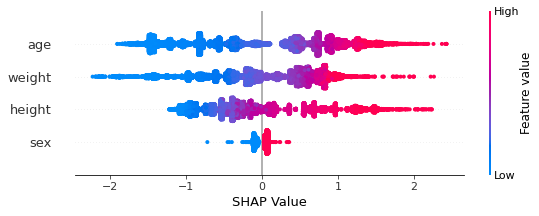

In [7]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Gradient-boosted regression tree model
gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/depth/mae-0.706_rmse-0.884_r20.831_gbrt_uncuff_10nfold/model.model')

shap.initjs()
explainer = shap.TreeExplainer(gbrt_uncuff)
shap_values = explainer.shap_values(xgb.DMatrix(x_uncuff_train))


INPUT_VARS = ['age', 'sex', 'weight','height']

X_train = pd.DataFrame(x_uncuff_train, columns=INPUT_VARS)

fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, show=False)
ax.set_xlabel('SHAP Value')
#ax.set_title('SHAP Dot Plot', fontsize=20)
plt.savefig("figures/Suppl_Fig1_c_depth_uncuff_SHAP.png", dpi=600)
plt.show()

### dependence plot

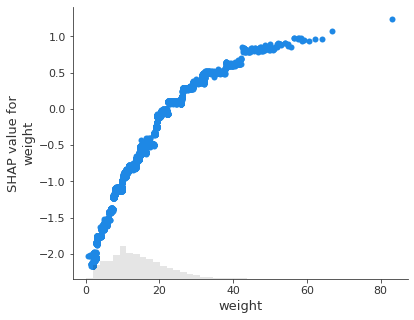

In [12]:
# plot shap summary plot
INPUT_VARS = ['age', 'sex', 'weight','height']

X_train = pd.DataFrame(x_uncuff_train, columns=INPUT_VARS)

shap_xgb = explainer(X_train)
var = 'weight'
shap.plots.scatter(shap_xgb[:,var], dot_size = None, show=False)
#plt.rcParams['font.family'] = 'AvenirNextLTPro'
plt.savefig(f"figures/Suppl_Fig2_i_depth_uncuff_{var}.png", dpi=600, bbox_inches='tight', pad_inches=0.5)

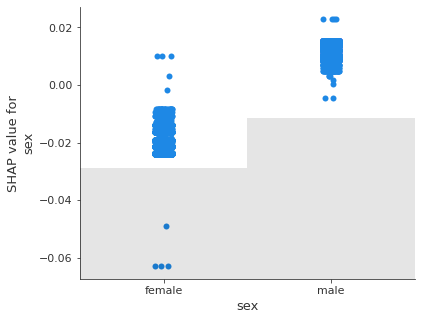

In [13]:
shap.plots.scatter(shap_xgb[:,'sex'], x_jitter=0.1, dot_size = None, show=False)
plt.xticks([0,1], ['female', 'male'])
plt.savefig("figures/Suppl_Fig2_h_depth_uncuff_sex.png", dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()

## Cuffed model

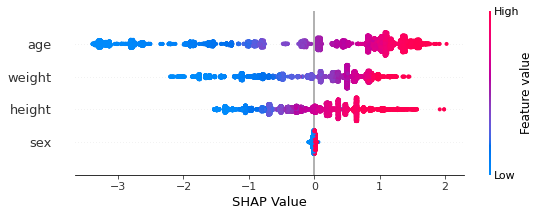

In [8]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Loading Gradient-boosted regression tree model
gbrt_cuff = xgb.XGBRegressor()
gbrt_cuff.load_model('result/revision1/depth/mae-0.722_rmse-1.005_r20.902_gbrt_cuff_10nfold/model.model')

# calculation of shap values
shap.initjs()
explainer = shap.TreeExplainer(gbrt_cuff)
shap_values = explainer.shap_values(xgb.DMatrix(x_cuff_train))


# plot shap summary plot
INPUT_VARS = ['age', 'sex', 'weight','height']

X_train = pd.DataFrame(x_cuff_train, columns=INPUT_VARS)

fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, show=False)
ax.set_xlabel('SHAP Value')
#ax.set_title('SHAP Dot Plot', fontsize=20)
plt.savefig("figures/Suppl_Fig1_d_size_cuff_SHAP.png", dpi=600)
plt.show()

### dependence plot

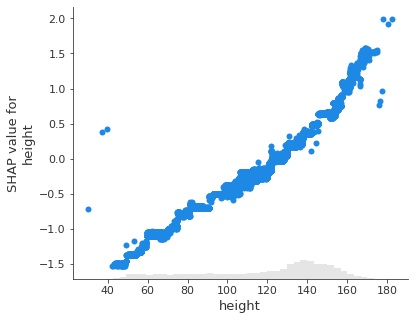

In [17]:
# plot shap summary plot
INPUT_VARS = ['age', 'sex', 'weight','height']

X_train = pd.DataFrame(x_cuff_train, columns=INPUT_VARS)

shap_xgb = explainer(X_train)
var = 'height'
shap.plots.scatter(shap_xgb[:,var], dot_size = None, show=False)
#plt.rcParams['font.family'] = 'AvenirNextLTPro'
plt.savefig(f"figures/Suppl_Fig2_n_depth_cuff_{var}.png", dpi=600, bbox_inches='tight', pad_inches=0.5)

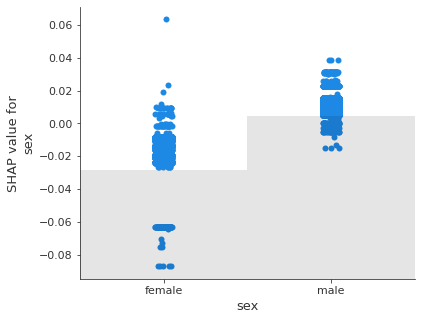

In [15]:
shap.plots.scatter(shap_xgb[:,'sex'], x_jitter=0.1, dot_size = None, show=False)
plt.xticks([0,1], ['female', 'male'])
plt.savefig("figures/Suppl_Fig2_l_depth_cuff_sex.png", dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()